# NYC Airbnb Price Prediction - XGBoost model training

Use dataset published by Kaggle - https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data - to train a simple XGBoost model to predict prices for Airbnb properties.

This notebook contains the code to train the model from the dataset prepared in the airbnb_data_preparation notebook. It adapts the deep learning training notebook.


# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#buildpipe>Build pipeline</a>

<a href=#modelfit>Define and fit model</a>



# Common imports and global variable definitions

In [213]:

''' check to see if the notebook is being run in Colab, and if so, set the current directory appropriately'''
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/machine_learning_tabular_book/code/xgboost_basics/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/machine_learning_tabular_book/code/xgboost_basics/notebooks


In [214]:
import time
start_time = time.time()

In [215]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math
import sys
from subprocess import check_output
from IPython.display import display
#model libraries
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
#from tf.keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import TensorBoard
#import datetime
#from datetime import date
from sklearn import metrics
# import pipeline libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from custom_classes import encode_categorical
from custom_classes import prep_for_keras_input
from custom_classes import fill_empty
from custom_classes import encode_text


In [216]:
import tensorflow as tf
tf.__version__ 

'2.8.2'

In [217]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')


current directory is: /content/drive/MyDrive/machine_learning_tabular_book/code/xgboost_basics/notebooks
path_to_yaml /content/drive/MyDrive/machine_learning_tabular_book/code/xgboost_basics/notebooks/model_training_config.yml


In [218]:
# load parameters

repeatable_run = config['test_parms']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
trainproportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # switch to determine whether text columns are included in the model
save_model_plot = config['general']['save_model_plot'] # switch to determine whether to generate plot with plot_model
tensorboard_callback = config['general']['tensorboard_callback'] # switch to determine if tensorboard callback defined

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']
target_col = config['general']['target_col']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# date values
date_today = datetime.now()
print("date today",date_today)

# pickled original dataset and post-preprocessing dataset
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']

# experiment parameter

current_experiment = config['test_parms']['current_experiment']

# load lists of column categories
collist = config['categorical']
textcols = config['text']
continuouscols = config['continuous']
excludefromcolist = config['excluded']

date today 2022-09-20 20:39:15.289692


# Helper functions

In [219]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}


def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)




In [220]:
# get the paths required

def get_path():
    '''get the path for data files

    Returns:
        path: path for data files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files
    
    Returns:
        path: path for pipeline files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files
    
    Returns:
        path: path for model files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [221]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment 
    Args:
        experiment_number: filename containing config parameters
        count_no_delay: count of negative outcomes in the dataset
        count_delay: count of positive outcomes in the dataset

    Returns:
        early_stop: whether the experiment includes an early stop callback
        one_weight: weight applied to positive outcomes
        epochs: number of epochs in the experiment
        es_monitor: performance measurement tracked in callbacks
        es_mod: direction of performance being tracked in callbacks
    
    '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 0:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 1
    elif experiment_number == 9:
        #
        early_stop = True
        es_monitor="val_accuracy"
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        get_test_train_acc = False
        #
        epochs = 20    
    elif experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)






# Ingest data and create refactored dataframe <a name='ingestdash' />
- Ingest data for route information and delay information
- Create refactored dataframe with one row per route / direction / timeslot combination


<a href=#linkanchor>Back to link list</a>

In [222]:
def ingest_data(path):
    '''load list of valid routes and directions into dataframe
    Args:
        path: path for data files
    
    Returns:
        merged_data: dataframe loaded from pickle file
    '''
    file_name = os.path.join(path,pickled_dataframe)
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(merged_data)

In [223]:
def prep_merged_data(merged_data,target_col):
    '''add derived columns to merged_data dataframe
    Args:
        merged_data: input dataframe
        target_col: column that is the target
    
    Returns:
        merged_data: dataframe with derived columns added
    '''
    if targetcontinuous:
        merged_data['target'] = merged_data[target_col]
    else:
        merged_data['target'] = np.where(merged_data[target_col] >= merged_data[target_col].mean(), 1, 0 )
    return(merged_data)

# Master Prep Cell
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [224]:
# master calls

path = get_path()
print("path is",path)
# load route direction and delay data datframes
merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data,target_col)
print("shape of pre refactored dataset", merged_data.shape)
#merged_data['year'].value_counts()
#merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count under mean ",count_no_delay)
print("count over mean ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)

path is /content/drive/MyDrive/machine_learning_tabular_book/code/xgboost_basics/data
shape of pre refactored dataset (48895, 18)
shape of refactored dataset (48895, 18)
count under mean  34016
count over mean  14879
setting parameters for experiment  0
early_stop is  False
one_weight is  1.0
epochs is  1
es_monitor is  val_loss
es_mode is  min


In [225]:
merged_data.shape

(48895, 18)

# Define training, validation, and test subsets of the dataset

In [226]:
def get_train_validation_test(dataset):
    '''get training and test data set
    Args:
        dataset: input dataframe
    
    Returns:
        dtrain: training subset of dataset
        dvalid: validation subset of dataset
        dtest: test subset of dataset
    '''
    train, test = train_test_split(dataset, test_size = testproportion)
    dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(dtrain,dvalid,test)



# Build Pipeline <a name='buildpipe' />

Create pipeline objects to perform final data preparation steps for training and inference.

Note that cleanup on the training dataset is completed upstream in the [data cleanup notebook](https://github.com/ryanmark1867/end_to_end_deep_learning_liveproject/blob/master/notebooks/data_cleanup.ipynb). 
- The pipelines only accomplish the subset of preparation that is required for both training and inference
- Because the scoring data coming in for inference is forced by the web deployment to avoid the invalid values that the data cleanup notebook deals with, the pipelines don't have to deal with those problems.

<a href=#linkanchor>Back to link list</a>

In [227]:
print("collist is: ",str(collist))
print("textcols is: ",str(textcols))
print("continuouscols is: ",str(continuouscols))
print("excludefromcolist is: ",str(excludefromcolist))

collist is:  ['neighbourhood_group', 'neighbourhood', 'room_type']
textcols is:  []
continuouscols is:  ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
excludefromcolist is:  ['price', 'id', 'latitude', 'longitude', 'host_name', 'last_review', 'name', 'host_name', 'availability_365']


In [228]:
# master block to invoke pipeline

# build fully qualified names for the files for saving the pipelines
pipeline_path = get_pipeline_path()
pipeline1_file_name = os.path.join(pipeline_path,'sc_delay_pipleline'+modifier+'.pkl')
pipeline2_file_name = os.path.join(pipeline_path,'sc_delay_pipleline_keras_prep'+modifier+'.pkl')

# define column lists:
# collist,continuouscols,textcols = def_col_lists()

# create objects of the pipeline classes
fe = fill_empty()
ec = encode_categorical()
pk = prep_for_keras_input()
pk_valid = prep_for_keras_input()
pk_test = prep_for_keras_input()

# need to implement the pipeline in two parts:
# 1. fill empty + encode categoricals
# 2. prep for Keras
# because part 1 needs to be applied to the entire dataset and part 2 to the individual train, validate, and test sets


sc_delay_pipeline = Pipeline([('fill_empty',fe),('encode_categorical',ec)])
# need to have distinct pipeline objects for each subset of the dataset: train, validated and test
sc_delay_pipeline_keras_prep = Pipeline([('prep_for_keras',pk)])
sc_delay_pipeline_keras_prep_valid = Pipeline([('prep_for_keras',pk_valid)])
sc_delay_pipeline_keras_prep_test = Pipeline([('prep_for_keras',pk_test)])



# provide the value for each parameter of each of the pipeline classes

sc_delay_pipeline.set_params(fill_empty__collist = collist, fill_empty__continuouscols = continuouscols,
                            fill_empty__textcols = textcols,encode_categorical__col_list = collist)
sc_delay_pipeline_keras_prep.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)
sc_delay_pipeline_keras_prep_valid.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)
sc_delay_pipeline_keras_prep_test.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)

# fit the input dataset to the pipeline

# first fit the first segment of pipeline on the whole dataset
X = sc_delay_pipeline.fit_transform(merged_data)
max_dict = ec.max_dict
# then split dataset
dump(sc_delay_pipeline, open(pipeline1_file_name,'wb'))
dump(sc_delay_pipeline_keras_prep, open(pipeline2_file_name,'wb'))
dtrain, dvalid, test = get_train_validation_test(X)
# then apply second portion of pipeline to each subset
# need to have a distinct object for each to prevent first object impacting others

X_train_list = sc_delay_pipeline_keras_prep.fit_transform(dtrain)
X_valid_list = sc_delay_pipeline_keras_prep_valid.fit_transform(dvalid)
X_test_list = sc_delay_pipeline_keras_prep_test.fit_transform(test)

print("keras variables defined")
print("X_train_list",X_train_list)



fill empty xform
col is  neighbourhood_group
col is  neighbourhood
col is  room_type
transform col is  neighbourhood_group
after transform col is  neighbourhood_group
transform col is  neighbourhood
after transform col is  neighbourhood
transform col is  room_type
after transform col is  room_type
Through train test split. Test proportion:
0.2
cat col is neighbourhood_group
cat col is neighbourhood
cat col is room_type
cont col is minimum_nights
cont col is number_of_reviews
cont col is reviews_per_month
cont col is calculated_host_listings_count
cat col is neighbourhood_group
cat col is neighbourhood
cat col is room_type
cont col is minimum_nights
cont col is number_of_reviews
cont col is reviews_per_month
cont col is calculated_host_listings_count
cat col is neighbourhood_group
cat col is neighbourhood
cat col is room_type
cont col is minimum_nights
cont col is number_of_reviews
cont col is reviews_per_month
cont col is calculated_host_listings_count
keras variables defined
X_train_l

In [229]:
collist

['neighbourhood_group', 'neighbourhood', 'room_type']

In [230]:
# Features are
# neighbourhood_group
# neighbourhood
# room_type
# minimum_nights
# number_of_reviews
# reviews_per_month
# calculated_host_listings_count

X_train_list

[array([2, 2, 2, ..., 2, 2, 1]),
 array([209, 178,  61, ...,  94,  35, 214]),
 array([0, 0, 1, ..., 1, 0, 1]),
 array([ 2,  2,  2, ...,  1, 30,  1]),
 array([  0,   1,  49, ..., 594,  60,   1]),
 array([0.  , 0.86, 1.52, ..., 7.57, 1.38, 0.03]),
 array([1, 1, 5, ..., 3, 1, 3])]

In [231]:
max(X_train_list[0])

4

In [232]:
max(X_train_list[1])

220

In [233]:
max(X_train_list[2])

2

In [234]:
max(X_train_list[3])

999

In [235]:
len(X_train_list[0])

31292

In [236]:
len(dtrain.target)

31292

In [237]:
len(X_valid_list[0])

7824

In [238]:
len(dvalid)

7824

##Define and fit model <a name='modelfit' />
- the deep learning model requires a list of numpy arrays
- XGBoost requires a numpy array of lists, so the training and test datasets need to be transformed before the XGBoost model is fit

<a href=#linkanchor>Back to link list</a>

In [239]:
# get lists of lists for the training and test datasets
list_of_lists_train = []
list_of_lists_test = []
for i in range(0,7):
    list_of_lists_train.append(X_train_list[i].tolist())
    list_of_lists_test.append(X_test_list[i].tolist())

In [240]:
%%time
# convert lists of lists to numpy arrays of lists
xgb_X_train = np.array(list_of_lists_train).T
xgb_X_test = np.array(list_of_lists_test).T

CPU times: user 31.4 ms, sys: 990 µs, total: 32.4 ms
Wall time: 33.7 ms


In [241]:
xgb_X_train

array([[2.00e+00, 2.09e+02, 0.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [2.00e+00, 1.78e+02, 0.00e+00, ..., 1.00e+00, 8.60e-01, 1.00e+00],
       [2.00e+00, 6.10e+01, 1.00e+00, ..., 4.90e+01, 1.52e+00, 5.00e+00],
       ...,
       [2.00e+00, 9.40e+01, 1.00e+00, ..., 5.94e+02, 7.57e+00, 3.00e+00],
       [2.00e+00, 3.50e+01, 0.00e+00, ..., 6.00e+01, 1.38e+00, 1.00e+00],
       [1.00e+00, 2.14e+02, 1.00e+00, ..., 1.00e+00, 3.00e-02, 3.00e+00]])

In [242]:
%%time
# train XGBoost model using the same balancing factor as used for the deep learning model: one_weight
model_path = get_model_path()
xgb_save_model_path = os.path.join(model_path,'sc_xgbmodel'+modifier+"_"+str(experiment_number)+'.txt')
model = XGBClassifier()
model.fit(xgb_X_train, dtrain.target)
model.save_model(xgb_save_model_path)

CPU times: user 1.41 s, sys: 7.25 ms, total: 1.41 s
Wall time: 1.43 s


In [243]:
# apply model to the test dataset
y_pred = model.predict(xgb_X_test)
xgb_predictions = [round(value) for value in y_pred]

In [244]:
# evaluate predictions
xgb_accuracy = accuracy_score(test.target, xgb_predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

Accuracy: 80.48%


In [245]:
model.feature_importances_

array([0.0895112 , 0.0408557 , 0.77079415, 0.02295225, 0.02353807,
       0.01560383, 0.0367448 ], dtype=float32)

In [246]:
final_features = collist + continuouscols

In [247]:
final_features

['neighbourhood_group',
 'neighbourhood',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count']

In [248]:
np.array(final_features)

array(['neighbourhood_group', 'neighbourhood', 'room_type',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count'], dtype='<U30')

<BarContainer object of 7 artists>

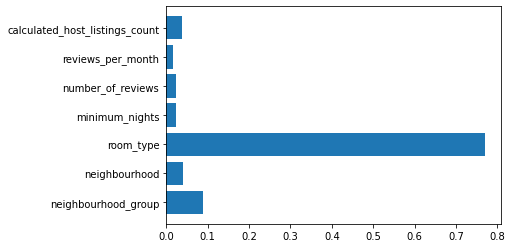

In [249]:

# plt.barh(boston.feature_names, rf.feature_importances_)
plt.barh(np.array(final_features), model.feature_importances_)

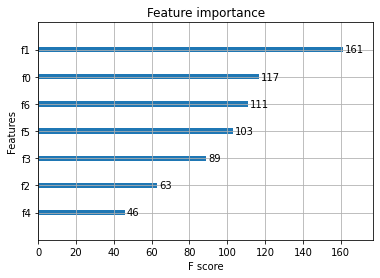

In [250]:
# plot trained model feature importance
plot_importance(model)
pyplot.show()

In [251]:
X_train_list

[array([2, 2, 2, ..., 2, 2, 1]),
 array([209, 178,  61, ...,  94,  35, 214]),
 array([0, 0, 1, ..., 1, 0, 1]),
 array([ 2,  2,  2, ...,  1, 30,  1]),
 array([  0,   1,  49, ..., 594,  60,   1]),
 array([0.  , 0.86, 1.52, ..., 7.57, 1.38, 0.03]),
 array([1, 1, 5, ..., 3, 1, 3])]

In [252]:
X_train_list[0]

array([2, 2, 2, ..., 2, 2, 1])

# Predictions and renderings

In [253]:
list(X_test_list[0])

[2,
 2,
 2,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 3,
 2,
 2,
 2,
 4,
 0,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 3,
 3,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 3,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 3,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 1,
 2,
 2,
 2,
 1,
 1,


## Confusion matrix

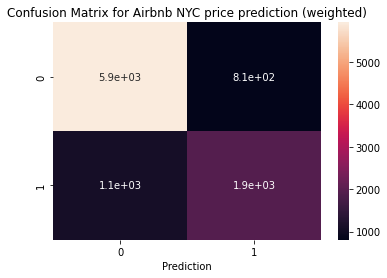

In [254]:
cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=y_pred)

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for Airbnb NYC price prediction (weighted)")
plt.show()

In [255]:

# print("elapsed time = ", end_time - start_time )
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.2388718128204346 seconds ---
